In [3]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

/Users/sesena/Documents/itu/epf/testenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [94]:
df = pd.read_csv('/Users/sesena/Documents/itu/epf/data_fetching/datasets/dataset_electricity_2016-01-01_2024-04-02.csv')

Extract the date and price columns and add a new column (item_id), to distiguish between different timeseries. We will conduct forecasting on a single timeseries, so we set it to '1'. Save the data to be read by the AutGluon TimeSeriesDataFrame.

In [95]:
df = df[['date', 'Price']]
df.columns = ['timestamp', 'target']
df['item_id'] = '1'
df.to_csv('electricity_price.csv', index=False)

Convert the data to AutoGluon TimeSeriesDataFrame class.

In [96]:
data = TimeSeriesDataFrame('electricity_price.csv')
data.head()

target
item_id timestamp                  
1       2016-01-01 00:00:00   30.75
        2016-01-01 01:00:00   30.83
        2016-01-01 02:00:00   23.95
        2016-01-01 03:00:00   15.15
        2016-01-01 04:00:00    6.06

Define the prediction horizon and perform train - test split.

In [97]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

In [98]:
test_data.tail()

target
item_id timestamp                  
1       2024-04-02 19:00:00   80.50
        2024-04-02 20:00:00   82.08
        2024-04-02 21:00:00   75.02
        2024-04-02 22:00:00   72.79
        2024-04-02 23:00:00   68.85

Feed our data to the model.

In [99]:
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(train_data, presets='chronos_tiny')

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240424_133224'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:31 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8112
CPU Count:          8
GPU Count:          0
Memory Avail:       3.09 GB / 16.00 GB (19.3%)
Disk Space Avail:   10.26 GB / 228.27 GB (4.5%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency:

Predit and plot.

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


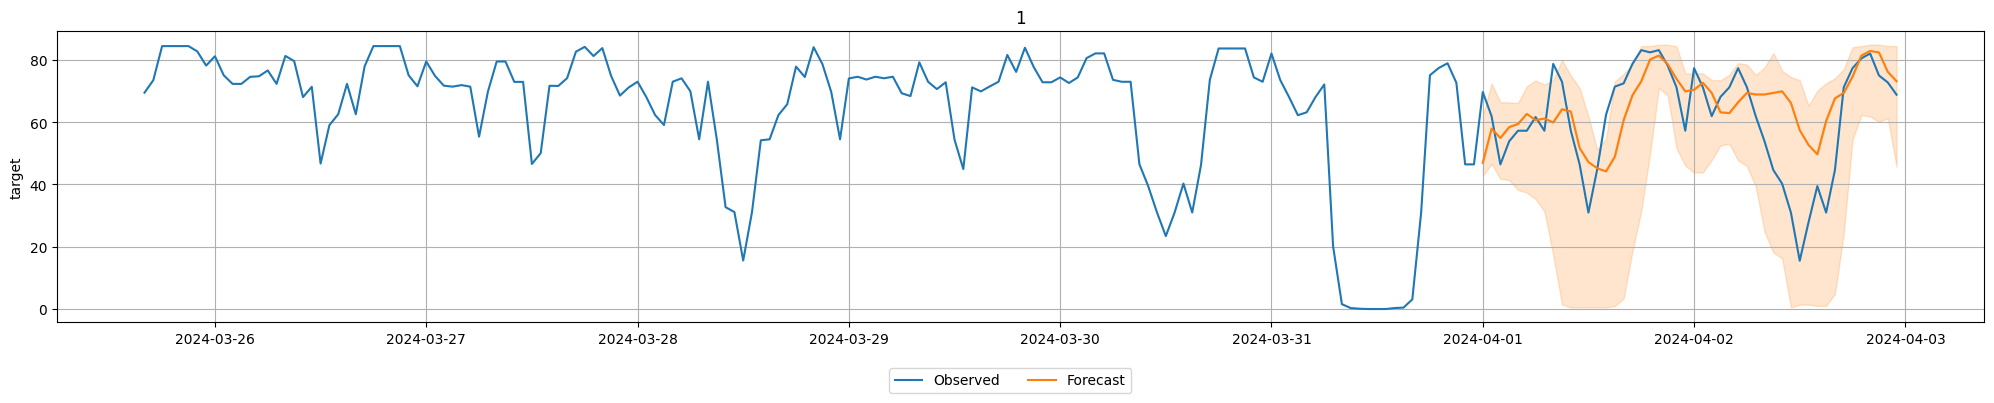

In [100]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=[1],
    max_history_length=200
)

In [103]:
df = pd.read_csv('/Users/sesena/Documents/itu/epf/data_fetching/datasets/dataset_electricity_2016-01-01_2024-04-02.csv')
df['item_id'] = '1'
df.columns = ['timestamp', 'target', 'BalancingMarketPrice', 'ForecastedDemandSupply', 'Day', 'Month', 'Year', 'Hour', 'Weekday', 'Holiday', 'Mod168', 'item_id']

In [104]:
data = TimeSeriesDataFrame(df)

In [105]:
prediction_length = 48
train_data, test_data = data.train_test_split(prediction_length=prediction_length)

In [107]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    known_covariates_names=['BalancingMarketPrice', 'ForecastedDemandSupply', 'Day', 'Month', 'Year', 'Hour', 'Weekday', 'Holiday', 'Mod168'],
    eval_metric='MASE'
).fit(train_data, presets='chronos_tiny')

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240424_133503'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.6
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:31 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8112
CPU Count:          8
GPU Count:          0
Memory Avail:       3.36 GB / 16.00 GB (21.0%)
Disk Space Avail:   10.20 GB / 228.27 GB (4.5%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': ['BalancingMarketPrice',
                            'ForecastedDemandSupply',
                            'Day',
                            'Month',
                            'Year',
                            'Hour',
                            'Weekday',
                            'H

In [108]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length)
future_timestamps = future_index.get_level_values('timestamp')
known_covariates = pd.DataFrame(index=future_index)

df['timestamp'] = pd.to_datetime(df['timestamp'])

known_covariates = df[(df['timestamp'] >= future_timestamps[0]) & (df['timestamp'] <= future_timestamps[-1])][['item_id', 'timestamp', 'BalancingMarketPrice', 'ForecastedDemandSupply', 'Day', 'Month', 'Year', 'Hour', 'Weekday', 'Holiday', 'Mod168']]

In [109]:
predictions = predictor.predict(train_data, known_covariates=TimeSeriesDataFrame(known_covariates))

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


In [110]:
predictor.evaluate(test_data, )

Model not specified in predict, will default to the model with the best validation score: Chronos[tiny]


{'MASE': -1.0298685967033596}

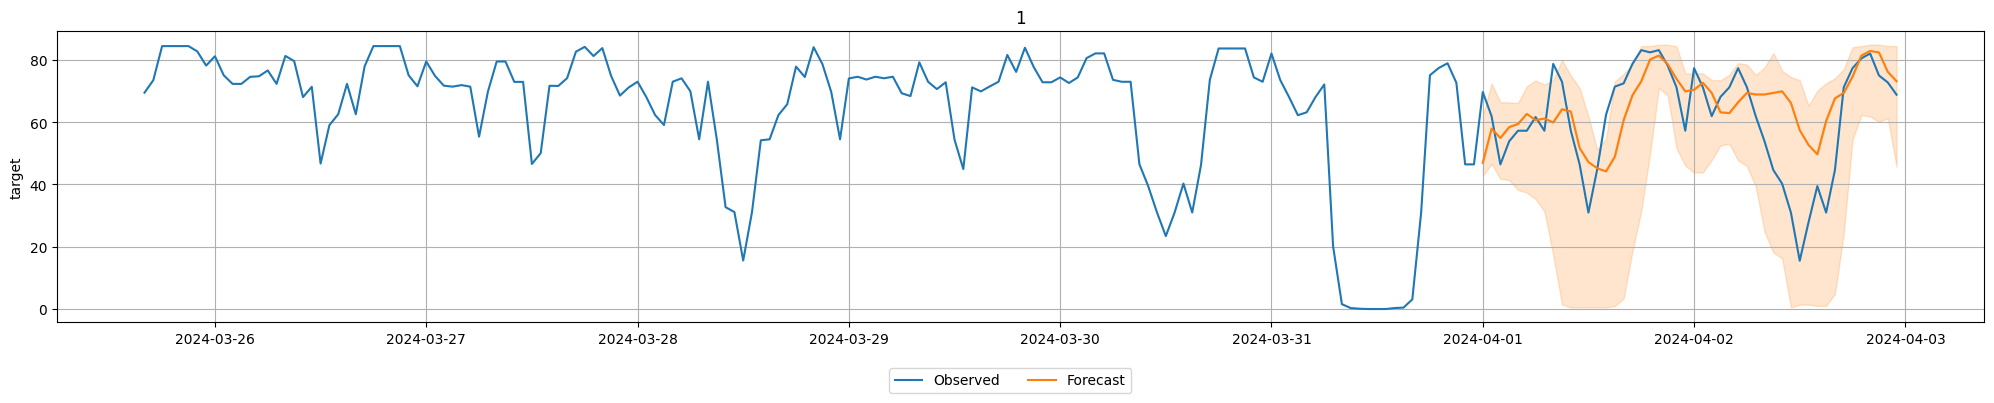

In [111]:
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=['1'],
    max_history_length=200
)

In [112]:
predictions

mean        0.1        0.2        0.3  \
item_id timestamp                                                         
1       2024-04-01 00:00:00  46.957230  42.860968  43.460388  46.957230   
        2024-04-01 01:00:00  57.947205  46.607545  46.957230  47.806445   
        2024-04-01 02:00:00  54.949940  41.811922  46.657497  51.503061   
        2024-04-01 03:00:00  58.446749  41.412286  45.458591  46.957230   
        2024-04-01 04:00:00  59.445837  38.265151  42.361423  47.456741   
        2024-04-01 05:00:00  62.692860  37.365946  45.658408  54.300508   
        2024-04-01 06:00:00  60.694681  35.317818  37.765614  51.852765   
        2024-04-01 07:00:00  61.194227  31.371416  31.471325  40.363246   
        2024-04-01 08:00:00  59.945381  17.284233  29.672939  40.313270   
        2024-04-01 09:00:00  64.191494   1.448708  25.576695  42.461312   
        2024-04-01 10:00:00  63.442194   0.499577   2.497728  43.660237   
        2024-04-01 11:00:00  51.702885   0.499577   2.098119  41.911810   
        2024-04-01 12:00:00  47.206985   0.499577   0.899186  37.166141   
        2024-04-01 13:00:00  45.208809   0.499577   0.499577  26.825553   
        2024-04-01 14:00:00  44.209721   0.499577   0.999089  30.821893   
        2024-04-01 15:00:00  48.955406   0.949137   1.798360  27.175211   
        2024-04-01 16:00:00  60.694681   3.346976  13.487703  27.924537   
        2024-04-01 17:00:00  68.687424  18.633031  27.974508  46.707416   
        2024-04-01 18:00:00  73.183323  31.471325  51.752856  58.596602   
        2024-04-01 19:00:00  80.176941  49.854586  61.943561  71.434937   
        2024-04-01 20:00:00  81.425819  71.035291  74.332283  76.480307   
        2024-04-01 21:00:00  78.678307  68.637453  71.135204  73.333172   
        2024-04-01 22:00:00  73.932625  51.702873  58.546632  70.036176   
        2024-04-01 23:00:00  69.936302  46.058018  48.555771  53.651125   
        2024-04-02 00:00:00  70.435844  43.810098  46.757412  57.897239   
        2024-04-02 01:00:00  72.683777  43.910007  53.751033  68.487613   
        2024-04-02 02:00:00  69.436760  47.806451  56.848175  59.695586   
        2024-04-02 03:00:00  63.192406  52.552127  58.146996  61.294128   
        2024-04-02 04:00:00  62.942650  53.051639  55.649295  58.446716   
        2024-04-02 05:00:00  66.439457  47.756500  60.844528  63.142434   
        2024-04-02 06:00:00  69.436756  45.908158  57.347752  62.143343   
        2024-04-02 07:00:00  68.937180  39.364126  58.346814  62.792760   
        2024-04-02 08:00:00  68.937214  24.777397  57.147934  62.443105   
        2024-04-02 09:00:00  69.436726  18.183412  51.852733  60.394948   
        2024-04-02 10:00:00  69.936272  16.235193  53.551189  66.039824   
        2024-04-02 11:00:00  66.189671   0.499577  50.753767  63.342284   
        2024-04-02 12:00:00  57.447660   1.398757  36.666611  46.957230   
        2024-04-02 13:00:00  52.701975   1.398757  28.973595  43.760147   
        2024-04-02 14:00:00  49.704706   0.999089  24.577580  42.561240   
        2024-04-02 15:00:00  60.444925   0.999089  35.068069  48.305989   
        2024-04-02 16:00:00  67.688332   4.845583  36.866403  55.599323   
        2024-04-02 17:00:00  69.436756  24.177945  47.256950  61.643831   
        2024-04-02 18:00:00  74.681953  54.400437  60.245075  64.391304   
        2024-04-02 19:00:00  81.425819  62.343161  70.335906  74.132472   
        2024-04-02 20:00:00  82.924423  61.843649  78.228734  78.778209   
        2024-04-02 21:00:00  82.424877  60.145166  72.433995  79.127915   
        2024-04-02 22:00:00  76.180588  61.294147  66.539391  71.734627   
        2024-04-02 23:00:00  73.183323  45.658415  49.654736  67.138832   

                                   0.4        0.5        0.6        0.7  \
item_id timestamp                                                         
1       2024-04-01 00:00:00  46.957230  46.957230  48.455843  54.949940   
        2024-04-01 01:00:00  53.451275  57.947205  61.9435

### Compare the AutGluon Chronos Model with EPFToolBox's DNN model.

In [113]:
# get last 48 hours of df
last_24_hours = df[df['timestamp'] >= future_timestamps[0]]


# Calculate the MAE between last_24_hours' target columnd and the predictions' 'mean' column
from sklearn.metrics import mean_absolute_error
mean_absolute_error(last_24_hours['target'], predictions['mean'])


10.512433706919351

In [85]:
epf_toolbox_predictions = [60.17084503173828,55.24348831176758,49.616493225097656,45.469749450683594,43.40630340576172,47.48219680786133,47.252777099609375,49.61334228515625,59.32696533203125,56.1822624206543,51.87666320800781,51.03044128417969,40.4066276550293,46.82324981689453,59.19480895996094,54.537437438964844,66.11116027832031,72.55369567871094,80.01597595214844,79.81178283691406,75.01373291015625,70.68053436279297,61.56367492675781,64.46548461914062]
epf_toolbox_real_values = [69.69, 61.95, 46.46, 53.89, 57.27, 57.27, 61.67, 57.27, 78.75, 73.0, 57.3, 46.46, 30.97, 44.91, 62.41, 71.44, 72.48, 78.75, 83.16, 82.45, 83.16, 78.21, 71.24, 57.27]

mean_absolute_error(epf_toolbox_real_values, epf_toolbox_predictions)

8.421870829264323

In [114]:
gluon_real_values = list(last_24_hours['target'])
gluon_real_values = gluon_real_values[:24]

In [115]:
gluon_predictions = list(predictions['mean'])
gluon_predictions = gluon_predictions[:24]

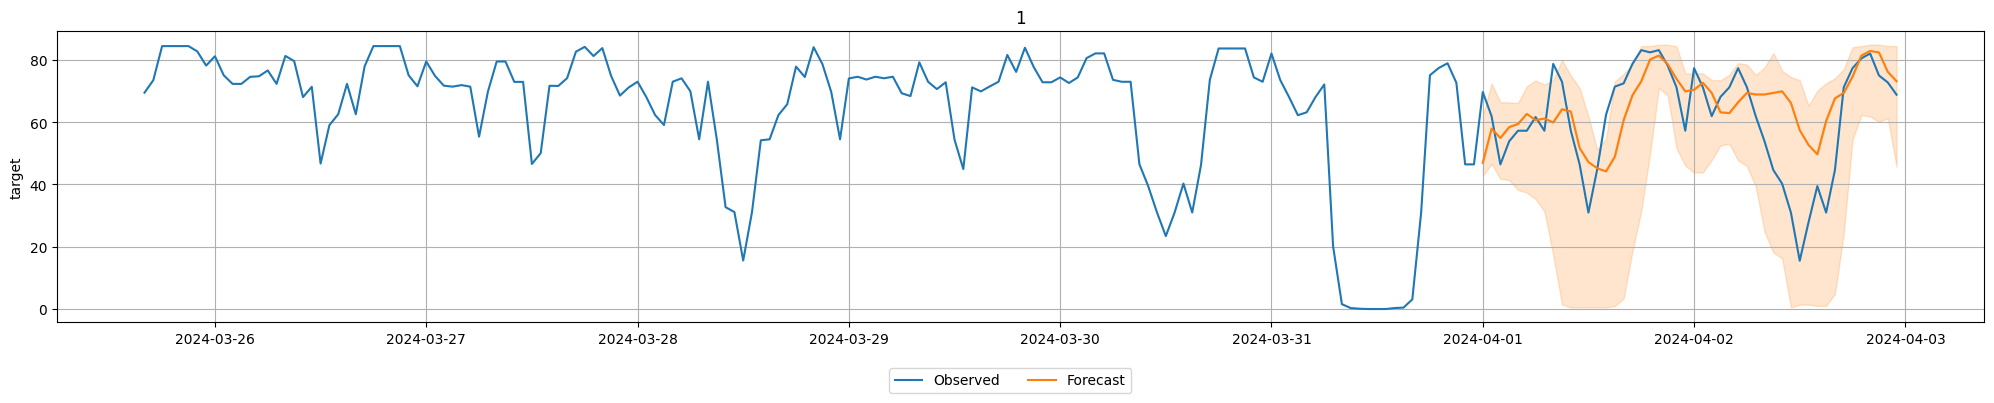

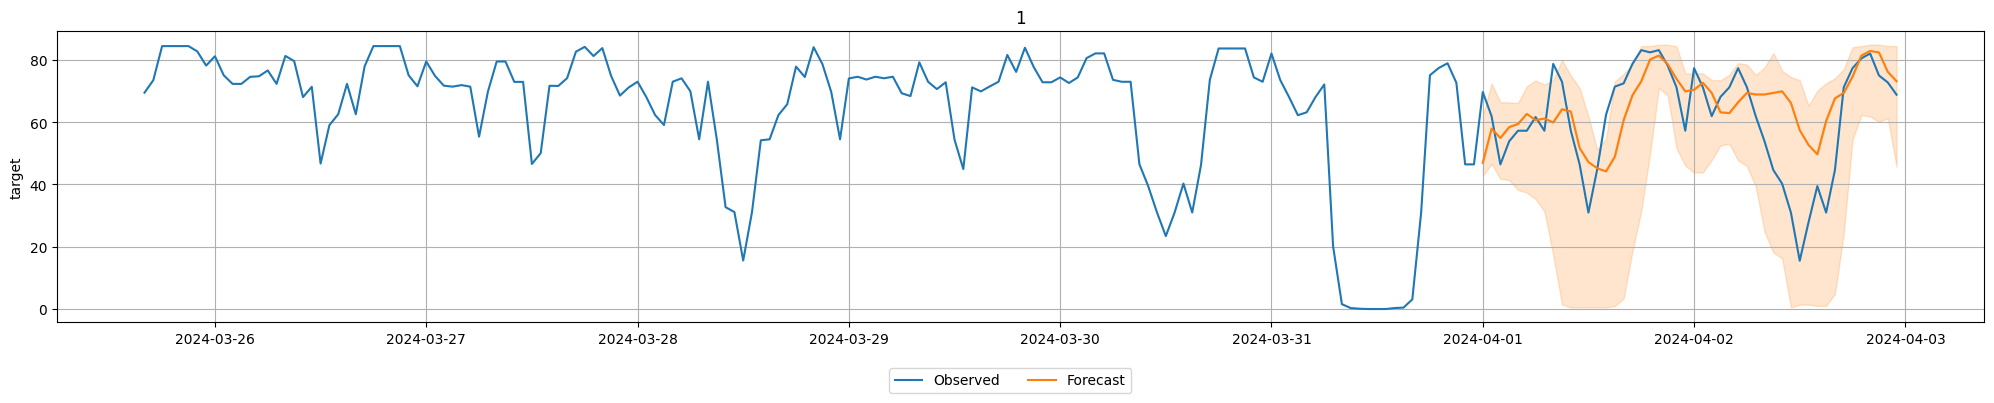

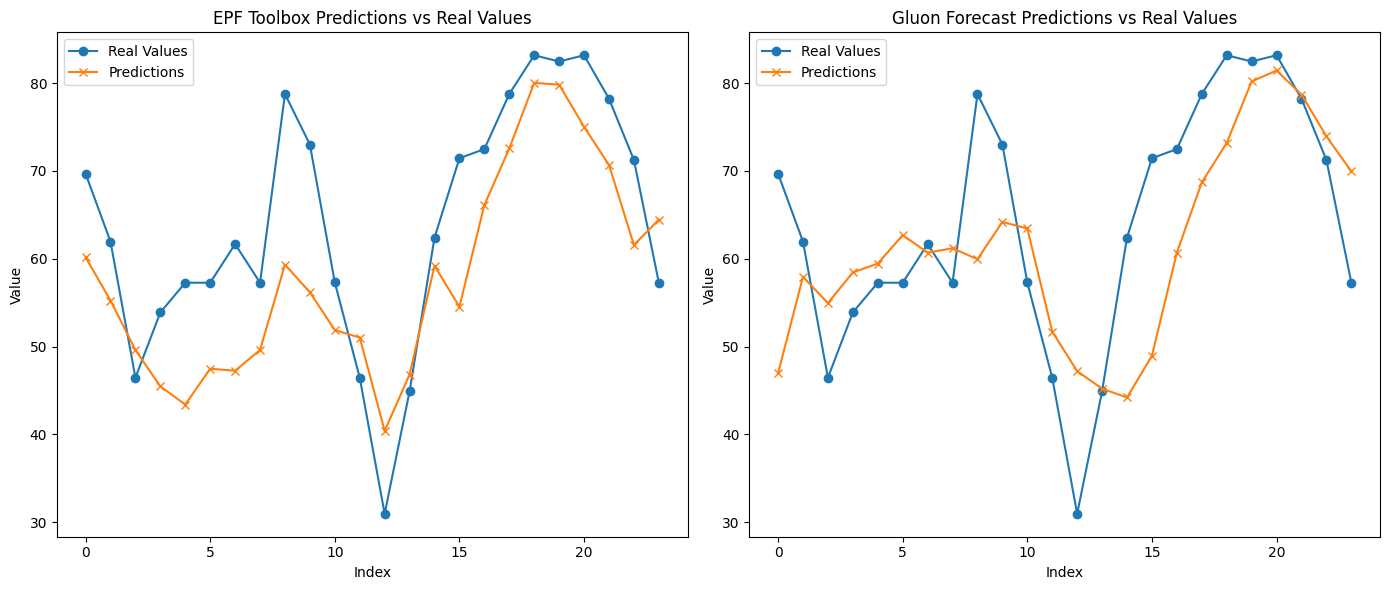

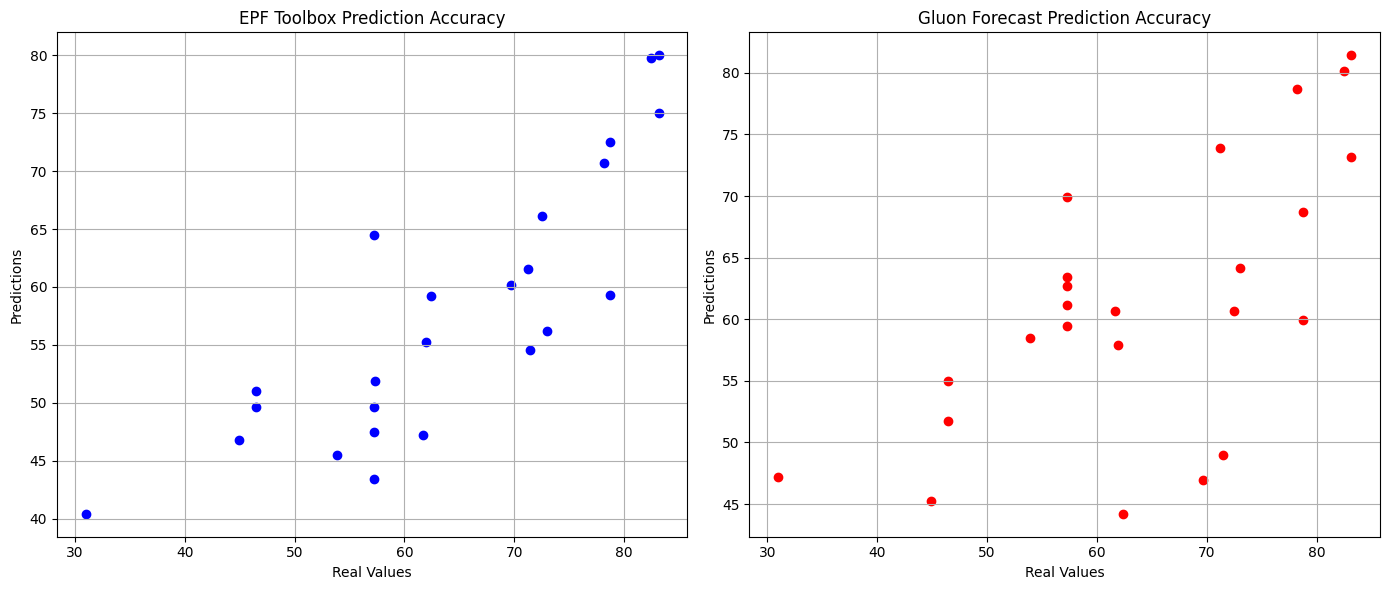

In [116]:
import matplotlib.pyplot as plt

# First set of data (EPF Toolbox)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epf_toolbox_real_values, label='Real Values', marker='o')
plt.plot(epf_toolbox_predictions, label='Predictions', marker='x')
plt.title('EPF Toolbox Predictions vs Real Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

# Second set of data (Gluon Forecast)
plt.subplot(1, 2, 2)
plt.plot(gluon_real_values, label='Real Values', marker='o')
plt.plot(gluon_predictions, label='Predictions', marker='x')
plt.title('Gluon Forecast Predictions vs Real Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

# Scatter Plot for EPF Toolbox
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(epf_toolbox_real_values, epf_toolbox_predictions, color='blue')
plt.title('EPF Toolbox Prediction Accuracy')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.grid(True)

# Scatter Plot for Gluon Forecast
plt.subplot(1, 2, 2)
plt.scatter(gluon_real_values, gluon_predictions, color='red')
plt.title('Gluon Forecast Prediction Accuracy')
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.grid(True)

plt.tight_layout()
plt.show()
